# View Labelled Distribution

Visualize The Label Distribution

In [69]:
import os
import re
import urllib
import tarfile
import sqlite3
import logging
import sys
import json
import pickle

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

from IPython.display import display, clear_output, HTML, JSON

## Connect and Load Data From DB

In [4]:
reviews_db = "var/reviews.db"

db = sqlite3.connect(reviews_db)

In [119]:
reviews = pd.read_sql("""
    select
        r.*,
        e.review_embedding
    from reviews r
    left join review_embeddings e on (e.id = r.id)
""", db)
reviews['review_embedding'] = reviews.review_embedding.apply(lambda et: np.array(json.loads(et)))

In [120]:
labels = pd.read_sql("select * from watch_labels", db)

In [121]:
titles = pd.read_sql("""
    select *
    from titles t
    where
        t.titleId in (
            select titleId
            from reviews
        )
""", db)

In [124]:
reviews = pd.merge(
    reviews,
    labels,
    on = 'id',
    how = 'left'
)
reviews = pd.merge(
    reviews,
    titles,
    on = 'titleId',
    how = 'left'
)

## View Embeddings in 2D

See how the chosen labels from active learning were distributed over the input space vs random selection.

My thought is that Active Learning should show that the items that were labelled should be more distributed over space better than random choice. Random choice of items in the input space should be more clustered.

In [126]:
# Condense the 50 dimensional vector down to 2 dimentions for graphing.
pca = PCA(n_components = 2)
pca.fit(np.vstack(reviews['review_embedding']))

PCA(n_components=2)

In [127]:
# This covers about 15% of information.
pca.explained_variance_ratio_.sum()

0.15521009526777285

In [128]:
unlabelled_2d = pca.transform(np.vstack(reviews[reviews.wanted.isnull()].review_embedding)).T
wanted_2d = pca.transform(np.vstack(reviews[reviews.wanted == 1.0].review_embedding)).T
unwanted_2d = pca.transform(np.vstack(reviews[reviews.wanted == 0.0].review_embedding)).T
random_2d = pca.transform(np.vstack(reviews.sample(100).review_embedding)).T

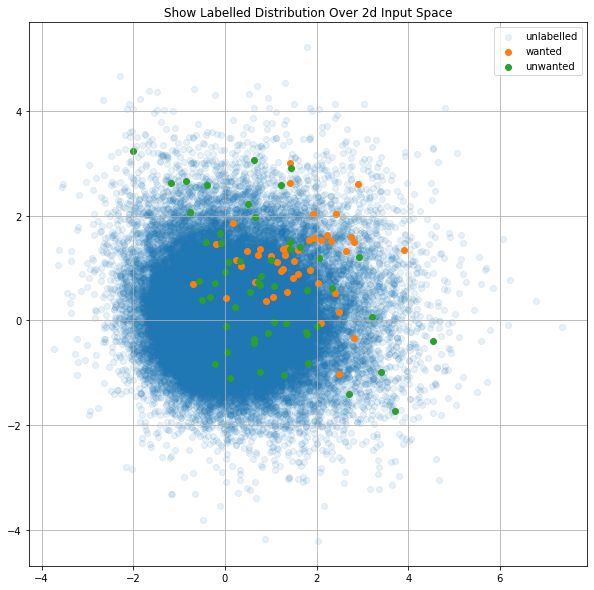

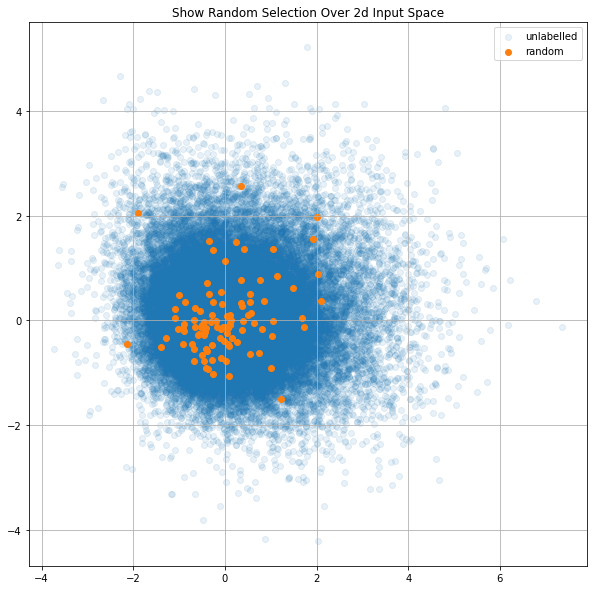

In [129]:
plt.figure(figsize=(10, 10))
plt.title("Show Labelled Distribution Over 2d Input Space")
plt.scatter(unlabelled_2d[0], unlabelled_2d[1], alpha=0.1, label='unlabelled')
plt.scatter(wanted_2d[0], wanted_2d[1], alpha=1, label='wanted')
plt.scatter(unwanted_2d[0], unwanted_2d[1], alpha=1, label='unwanted')

plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Show Random Selection Over 2d Input Space")
plt.scatter(unlabelled_2d[0], unlabelled_2d[1], alpha=0.1, label='unlabelled')
plt.scatter(random_2d[0], random_2d[1], alpha=1, label='random')

plt.legend()
plt.grid()
plt.show()

In [165]:
km = MiniBatchKMeans(n_clusters=25)
km.fit(np.vstack(reviews['review_embedding']))
reviews['cluster'] = km.predict(np.vstack(reviews['review_embedding']))

c:\users\bryan\source\repos\castle_analysis\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


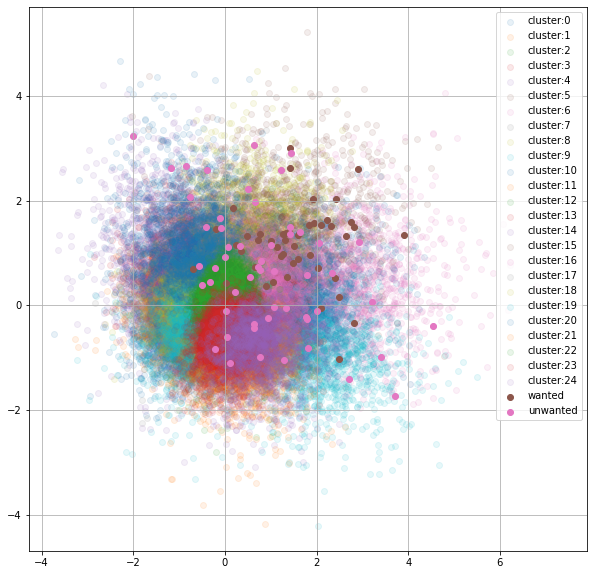

In [166]:
c_name = 0
plt.figure(figsize=(10, 10))
for cluster, review_c in reviews.groupby('cluster'):
    cluster_2d = pca.transform(np.vstack(review_c.review_embedding)).T
    plt.scatter(cluster_2d[0], cluster_2d[1], alpha=0.1, label=f"cluster:{c_name}")
    c_name += 1
 
plt.scatter(wanted_2d[0], wanted_2d[1], alpha=1, label='wanted')
plt.scatter(unwanted_2d[0], unwanted_2d[1], alpha=1, label='unwanted')
plt.grid()
plt.legend()
plt.show()

## How to predicted probabilities map to clusters?

In [131]:
os.listdir("var/models")

['review_model.d2v', 'wanted_review.pkl']

In [132]:
with open("var/models/wanted_review.pkl", "rb") as fh:
    model = pickle.load(fh)

In [133]:
r = model.predict_proba(np.vstack(reviews['review_embedding'])).T

In [134]:
reviews['bad_p'] = r[0]
reviews['good_p'] = r[1]

In [167]:
(reviews
    .agg({'good_p': ['mean', 'std', 'min', 'max', len]})
    .reset_index()
)

,index,good_p
0,mean,0.229347
1,std,0.115179
2,min,0.020000
3,max,0.900000
4,len,100000.000000


In [168]:
(reviews
    .groupby('cluster')
    .agg({'good_p': ['mean', 'std', 'min', 'max', len]})
    .reset_index()
    .sort_values(by=[('good_p', 'mean')], ascending=False)
)

cluster    good_p                             
                mean       std   min   max    len
5        5  0.507969  0.110310  0.15  0.89    965
6        6  0.496746  0.104381  0.19  0.90   1512
15      15  0.445742  0.107947  0.14  0.81    620
10      10  0.374504  0.115682  0.10  0.83   1974
9        9  0.363745  0.103508  0.10  0.80   2115
8        8  0.362946  0.118402  0.08  0.87   3109
16      16  0.338134  0.117235  0.04  0.87   3349
20      20  0.303631  0.108126  0.06  0.75   2253
24      24  0.290806  0.104704  0.04  0.70   2283
4        4  0.272837  0.099298  0.06  0.65   1939
1        1  0.257934  0.099661  0.04  0.80   6447
14      14  0.254651  0.081689  0.07  0.62   1561
2        2  0.234819  0.093703  0.03  0.82   4009
21      21  0.231710  0.093944  0.04  0.61   2590
18      18  0.230731  0.098195  0.02  0.84   5032
17      17  0.224763  0.087139  0.03  0.60   1984
13      13  0.224584  0.086696  0.05  0.57   3617
19      19  0.220252  0.089945  0.04  0.67   2503
23      23  0.218776  0.081308  0.03  0.63   5635
11      11  0.202374  0.084391  0.03  0.82   3555
3        3  0.192333  0.079308  0.02  0.55   5396
12      12  0.190497  0.074257  0.03  0.61   4330
7        7  0.164747  0.067608  0.02  0.61  11971
0        0  0.161169  0.056603  0.03  0.48  10845
22      22  0.159822  0.063965  0.02  0.53  10406

In [176]:
for _, r in reviews[reviews.cluster == 5].sample(5).iterrows():
    print(f"good: {r.good_p}")
    print(r.review)
    print("-------------------")

good: 0.66
It doesn't happen very often, but occasionally one man can make a difference -- a big difference.<br /><br />George Crile's 2003 best seller, CHARLIE WILSON'S WAR, is a fascinating and eye-opening account of the most unlikely "difference maker" imaginable. A relatively obscure Congressman from the Second District of Texas, "Good Time Charlie" was known more for his libertine lifestyle than his libertarian legislation. Likable and licentious (even for a politician), Charlie Wilson served his constituency well since the good folks of Lufkin only really wanted two things, their guns and to be left alone. It's Easy Street replete with his bevy of beltway beauties known, appropriately enough, as Charlie's Angels.<br /><br />When asked why his entire office staff was composed of attractive, young aides his response is a classic, "You can teach 'em to type, but you can't teach 'em to grow tits." No argument there.<br /><br />But even the most rakish rapscallion has a conscience lur